# Final Project
## Tyler Baker and Rathish Parayil Sasidharan

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters.

## Introduction


### Setting the Environment

In [108]:
import pandas as pd
import numpy as np
import networkx as nx
import nltk
import random
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import re
import string
import math
import collections

import community
from community import community_louvain
from collections import defaultdict
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### The Data
We got our data from <a href="https://www.kaggle.com/datasets/omkarsabnis/yelp-reviews-dataset?resource=download">Kaggle</a>.

In [5]:
data_raw = pd.read_csv("https://raw.githubusercontent.com/tylerbaker01/Data-620/main/yelp.csv")

### Part 1 SNA

**Overview**

We will build a bipartite network using the restaurant review data and project a user network, perform centrality measures to identify the prominent reviewers.


#### Data Prepations


In [32]:
#load the data
#data_sn_raw = pd.read_csv("D:\Personal\Masters\Rathish-Personal\CUNY\Summer-22\Rathish\FinalProject\yelp_modified.csv")
#data_sn_raw = pd.read_csv("D:\Personal\Masters\Rathish-Personal\CUNY\Summer-22\Rathish\FinalProject\yelp.csv")
data_sn_raw = data_raw

In [34]:
data_sn_raw.head(5)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [107]:
# Data clean up
print(data_sn_raw.shape)

#check if there any missing value present in the business_id / review_id column
print(data_sn_raw['business_id'].isnull().sum())
print(data_sn_raw['user_id'].isnull().sum())

(10000, 10)
0
0


We could see that there are no missing nodes. So we could use the data

### Created a Bipartite Graph of Users and Restuarents


In [36]:
reviewsG = nx.Graph()
for r, d in data_sn_raw.iterrows():
    userId = 'USR_{0}'.format(d['user_id'])  
    businessId = 'BSN_{0}'.format(d['business_id'])
    reviewsG.add_node(userId, bipartite = 0)
    reviewsG.add_node(businessId, bipartite = 1)
    reviewsG.add_edge(userId, businessId, weight=d['stars'])

Let's check some network characteristics:

In [39]:
print("Bipartite Network G\n  Bipartite: {}\n  Connected: {}".format(nx.is_bipartite(reviewsG), 
                                                                 nx.is_connected(reviewsG)))

Bipartite Network G
  Bipartite: True
  Connected: False


Since the network has some unconnected subgraphs, we will remove these and work on the largest connected subgraph.

In [40]:
Gsub = max(nx.connected_component_subgraphs(reviewsG), key=len)
print(nx.info(Gsub))


Name: 
Type: Graph
Number of nodes: 6753
Number of edges: 7722
Average degree:   2.2870


The diameter is the longest of all the calculated path lengths. The diameter is representative of the linear size of a network.

We could see that the largest connected network 6753 nodes and 7722 edges

#### Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Users and second set is a Business. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no direct connection between Users or Business.

In [15]:
print('Network diameter =', nx.diameter(Gsub))

Network diameter = 24


C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


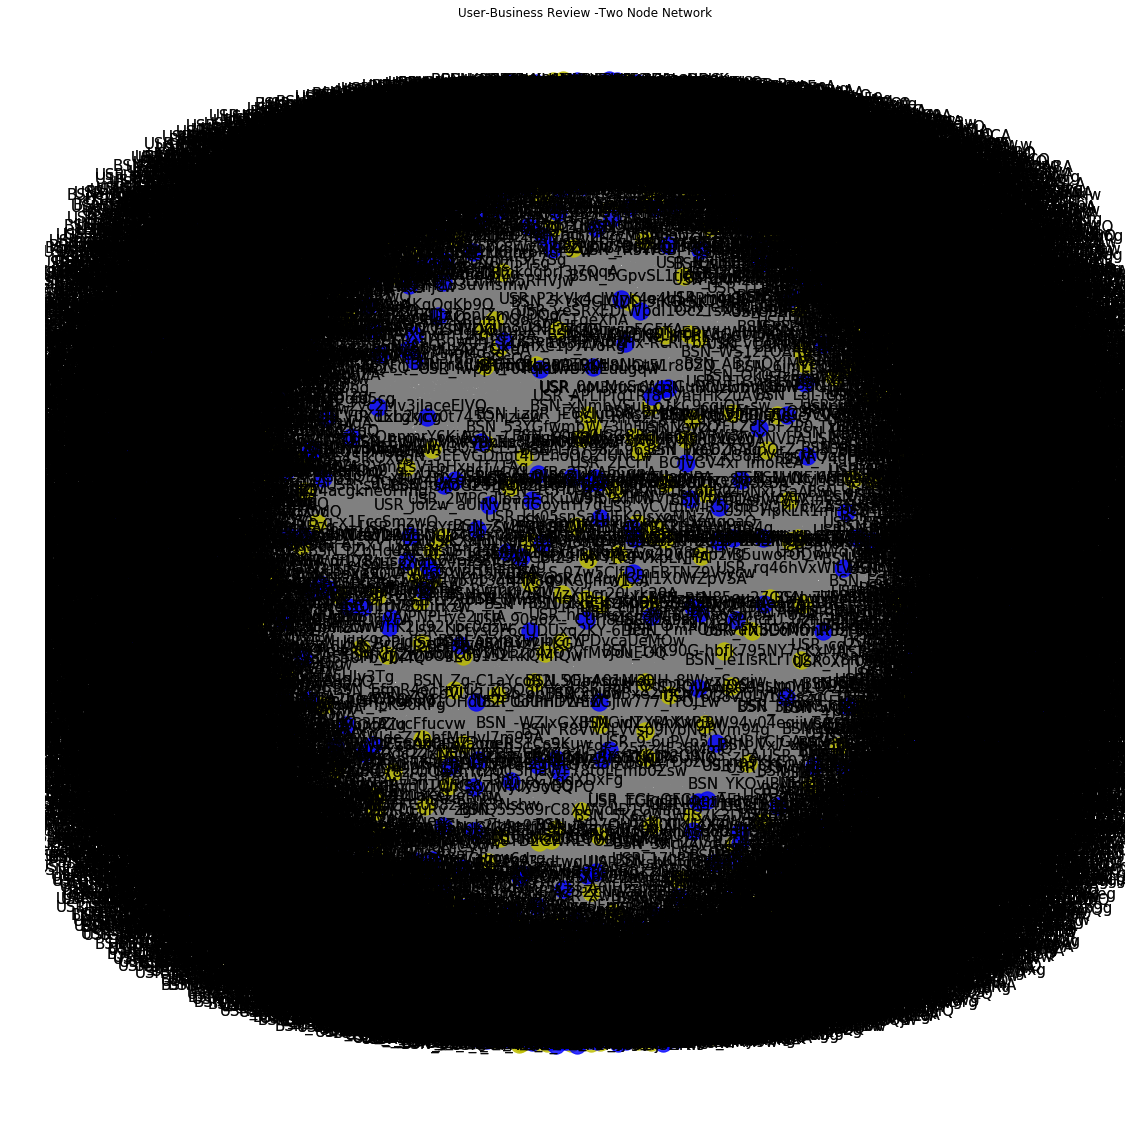

In [16]:
%matplotlib inline

fig = plt.figure(figsize=(15, 15))

businessList, usersList = nx.bipartite.sets(Gsub)

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(Gsub, k=0.5, iterations=25)
nx.draw(Gsub, nodelist = businessList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(Gsub, nodelist = usersList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('User-Business Review -Two Node Network')
plt.show()

**Create the weighted projected graph of User.**

In [42]:
#Create Bipartite Node Sets for Users and Restaurents
businessList, usersList = nx.bipartite.sets(Gsub)
len(usersList), len(businessList)

(4318, 2435)

In [43]:
# let's check the density of the user nodes
nx.bipartite.density(Gsub, usersList)

0.0007344262544546348

In [44]:
UserPrjG = nx.bipartite.weighted_projected_graph(Gsub, usersList, ratio=False)

#businessPrjG = nx.bipartite.weighted_projected_graph(Gsub, businessList, ratio=False)


Let's look at the resulting weighted projected graph of users.

In [45]:
print(nx.info(UserPrjG))

Name: 
Type: Graph
Number of nodes: 4318
Number of edges: 24181
Average degree:  11.2001


In [46]:
triadic_closure = nx.transitivity(UserPrjG)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.5700451628746223


**Cliques**

A clique is defined as a maximal complete subgraph of a given graph. 
For each node n, a maximal clique for n is a largest complete subgraph containing n.

In [82]:
cliques = nx.number_of_cliques(UserPrjG)
cliquesDf = pd.DataFrame(list(cliques.items()), columns=['Node', 'Cliques'])
cliquesDf.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
cliquesDf.head(10)

,Node,Cliques
3023,USR_fczQCSmaWF78toLEmb0Zsw,29
360,USR_wHg1YkCzdZq9WBJOTRgxHQ,24
2722,USR_90a6z--_CUrl84aCzZyPsg,21
1618,USR_rLtl8ZkDX5vH5nAx9C3q5Q,19
3685,USR_XqMkm-DD9VsdcKx2YVGhSA,19
2703,USR_JgDkCER12uiv4lbpmkZ9VA,19
3631,USR_0bNXP9quoJEgyVZu9ipGgQ,18
3173,USR_0CMz8YaO3f8xu4KqQgKb9Q,18
3471,USR_W_QXYA7A0IhMrvbckz7eVg,17
1105,USR__PzSNcfrCjeBxSLXRoMmgQ,16


### Communities Within the User Nodes

To understand what the weighted projected user network looks like, let's examine the communities within the network. Communities are identified using the Louvain detection method. Generally, commmunities are nodes within the network that are more densely connected to each other than other nodes, or the concept of modularity.

In [47]:
partitions = community_louvain.best_partition(UserPrjG)
set(partitions.values())

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37}

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


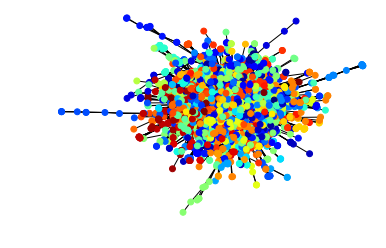

In [15]:
values = [partitions.get(node) for node in UserPrjG.nodes()]
spring_pos = nx.spring_layout(UserPrjG)
plt.axis("off")
nx.draw_networkx(UserPrjG, pos = spring_pos, 
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = 35, with_labels = False)

In [52]:
partitions_df = pd.DataFrame({'partition':partitions})

### Distribution of Users Within Communities

In [53]:
# function to generate histogram

def plot_dist(df, range, bins):

    # Plot the distribution of users within each community
    sns.set_style("whitegrid")    # Set style for seaborn output
    sns.set_context("notebook", font_scale=1.5)
    plt.figure(figsize=(8,8))
    plt.xticks(range)
    plt.xlabel("Partition")
    plt.ylabel("Frequency")
    plt.title("Distribution of Users Within Communities", fontsize=16)

    sns.distplot(partitions_df, bins=bins, kde=False, rug=False);

Plot the distribution on user nodes by partition as seen below. One partition in particular, 6, has the most users nodes.

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


<Figure size 6120x1080 with 0 Axes>

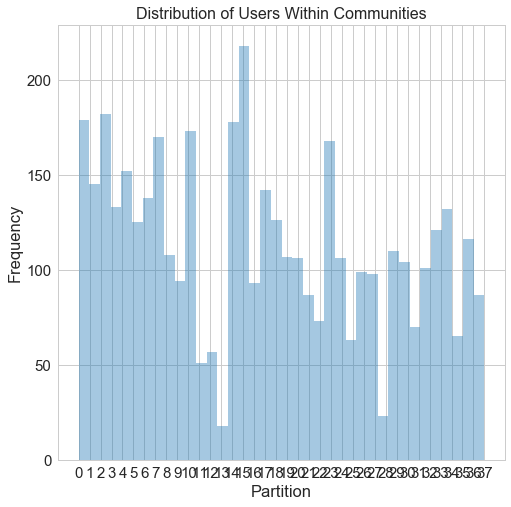

In [58]:
#plt.rcParams['figure.figsize'] = (85, 15)
plt.figure(figsize=(85, 15))

plot_dist(partitions_df, np.arange(0,38,1), 38);

In [59]:
partitions_df['partition'].value_counts()

15    218
2     182
0     179
14    178
10    173
7     170
23    168
4     152
1     145
17    142
6     138
3     133
34    132
18    126
5     125
33    121
36    116
29    110
8     108
19    107
24    106
20    106
30    104
32    101
26     99
27     98
9      94
16     93
37     87
21     87
22     73
31     70
35     65
25     63
12     57
11     51
28     23
13     18
Name: partition, dtype: int64

### Trim the User Network Using the Island Method

Apply the Island Method to the user network given the large number of nodes.

In [76]:
# Trim edges 

def trim_edges(g, weight=1):
    """
    Remove edges with weights less then a threshold parameter ("weight")
    """
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] >= weight:
              g2.add_edge(f,to,weight=edata['weight'])
     
    return g2
            

def island_method(g, iterations = 1):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))+1
    step = int((mx-mn)/iterations)
    print(mn)
    print(mx)
    print(step)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

Apply the Island Method to determine the minimim water level for trimming the network. 

In [63]:
print("Bipartite Network G\n  Bipartite: {}\n  Connected: {}".format(nx.is_bipartite(UserPrjG), 
                                                                 nx.is_connected(UserPrjG)))

Bipartite Network G
  Bipartite: False
  Connected: True


In [79]:
## Apply Island Analysis on the user nodes
islands = island_method(UserPrjG, 2)

1
3
1


In [80]:
print ('Weight  Users  Groups')
for i in islands:
   print('{}       {}       {}'.format(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Users  Groups
1       4318       1
2       51       23


In [81]:
print ('%-25s %-45s %-13s' % ('Rating more than', 'Nodes(Users + Review)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Rating more than          Nodes(Users + Review)                         Islands      
1                         4318                                          [4318]       
2                         51                                            [2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 4, 2]


In [66]:
print(len((islands[0])[1]))
nx.is_connected((islands[0])[1])

userPrjGSub = (islands[0])[1]

4318


### Calculate Centrality Measures of the User node

Closeness - Closeness is the inverse sum of all shortest paths 

Betweenness - Number of shortest paths that pass through a node 

Degree - The number other nodes that a node is connected to

In [67]:

#Closeness Betweenness Degrees centrality
def getAllCentalityMeasures( pGraph):
    closeCntrl = nx.closeness_centrality(pGraph)
    betweenCntrl = nx.betweenness_centrality(pGraph)
    degreeCntrl = nx.degree_centrality(pGraph)
    eigCntrl = nx.eigenvector_centrality(pGraph)   

    closeCntrldf1 = pd.DataFrame(list(closeCntrl.items()), columns=['Node', 'Closeness'])
    betweenCntrldf2 = pd.DataFrame(list(betweenCntrl.items()), columns=['Node', 'Betweenness'])
    degreeCntrldf3 = pd.DataFrame(list(degreeCntrl.items()), columns=['Node', 'Degrees'])
    eignCntrldf4 = pd.DataFrame(list(eigCntrl.items()), columns=['Node', 'Eigen'])

    dfFinal = closeCntrldf1.join(betweenCntrldf2.set_index('Node'), on='Node').join(degreeCntrldf3.set_index('Node'), on='Node').join(eignCntrldf4.set_index('Node'), on='Node')

    dfFinal.sort_values(['Eigen','Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
    #dfFinal.head(20)
    return dfFinal

print(getAllCentalityMeasures(userPrjGSub).head(20))

                           Node  Closeness  Betweenness   Degrees     Eigen
814  USR_8-2W5CmkDl9vrkxRpkiPRg   0.307632     0.024346  0.023164  0.150762
816  USR__PzSNcfrCjeBxSLXRoMmgQ   0.307150     0.023085  0.023396  0.145637
227  USR_X5GbNXY_nNoa_vTZDD0aCA   0.295989     0.015425  0.019226  0.138677
663  USR_o2CGc1kQHEFkYOECM3NFdg   0.305045     0.015402  0.015983  0.117709
467  USR_FxxYCRPcpd__yhRRmmtyMQ   0.299044     0.013021  0.013204  0.116992
265  USR_xZvRLPJ1ixhFVomkXSfXAw   0.303032     0.026458  0.017142  0.115921
202  USR_PDRWbCZa92irf8mK5X_Kig   0.296599     0.014362  0.018995  0.115034
843  USR_gdLc6dq1NpjHj47WBUNZ_A   0.291827     0.003676  0.012509  0.114825
815  USR_A_O8wZOsMTPwyeYA4-Rsow   0.293155     0.009673  0.014362  0.114161
846  USR_uA18GuF_ezOH6tXkrrykbw   0.294917     0.004536  0.010656  0.113192
821  USR_Znu5KKqytHfmjbXfQo3f4Q   0.291237     0.005839  0.011582  0.112861
817  USR_lAngRi4lwBIHmjCBVLd-8Q   0.280562     0.006076  0.011119  0.112299
845  USR_-jg

We could see that user distribution is almost unique and couldn't find any major differentiating factor.
So it seems like people who are visiting business randomly review

## Analysis of Bipartite SubGraph projected on Businesses

We will now consider the projection of the selected subgraph on businesses . 
Restaurant A will be connected with Restaurant B if it has been reviewed by same user. The weight of the edge will be established by the number of times this pair of restaurant has been reviewed by a same user.

In [83]:
businessPrjG = nx.bipartite.weighted_projected_graph(Gsub, businessList, ratio=False)

Lets  find some basic information about this graph.

In [84]:
print(nx.info(businessPrjG))
print ("Density: " + str(nx.density(businessPrjG)))
print ("Is connected?: " + str(nx.is_connected(businessPrjG)))
print ("Is bipartite?: " + str(nx.is_bipartite(businessPrjG)))

Name: 
Type: Graph
Number of nodes: 2435
Number of edges: 10515
Average degree:   8.6366
Density: 0.003548295114218658
Is connected?: True
Is bipartite?: False


We will now plot the Graph

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


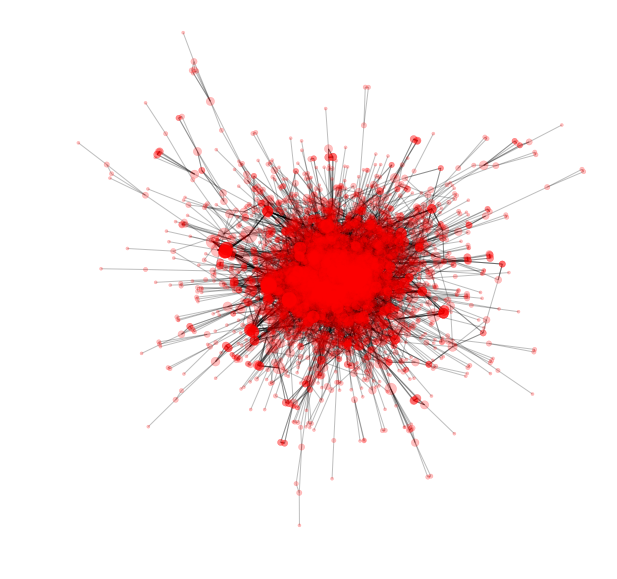

In [95]:
# Set the size of frame for drawing
plt.figure(figsize=(10,10))
plt.axis("off")

spring_pos = nx.spring_layout(businessPrjG)
nx.draw(businessPrjG, spring_pos, node_size=[val*10 for (node, val) in businessPrjG.degree()], with_labels=False, node_color='blue', alpha=.25)

### Cliques

In [86]:
businessCliques = nx.number_of_cliques(businessPrjG)
bCliquesDf = pd.DataFrame(list(businessCliques.items()), columns=['Node', 'Cliques'])
bCliquesDf.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
bCliquesDf.head(10)

,Node,Cliques
1582,BSN_JokKtdXU7zXHcr20Lrk29A,26
1643,BSN_VVeogjZya58oiTxK7qUjAQ,20
1785,BSN_EWMwV5V9BxNs_U6nNVMeqw,20
419,BSN_-sC66z4SO3tR7nFCjfQwuQ,20
1165,BSN_AqbgC7Gul5Es1rRzGNLDFA,19
1220,BSN_ntN85eu27C04nwyPa8IHtw,17
341,BSN_YKOvlBNkF4KpUP9q7x862w,17
1710,BSN_V1nEpIRmEa1768oj_tuxeQ,17
880,BSN_JhupPnWfNlMJivnWB5druA,17
1859,BSN_SDwYQ6eSu1htn8vHWv128g,16


**Communities Within the Business Nodes** 

To understand what the weighted projected business network looks like, let's examine the communities within the network. Communities are identified using the Louvain detection method. Generally, commmunities are nodes within the network that are more densely connected to each other than other nodes, or the concept of modularity.

In [87]:
business_Partitions = community_louvain.best_partition(businessPrjG)
set(business_Partitions.values())

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27}

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


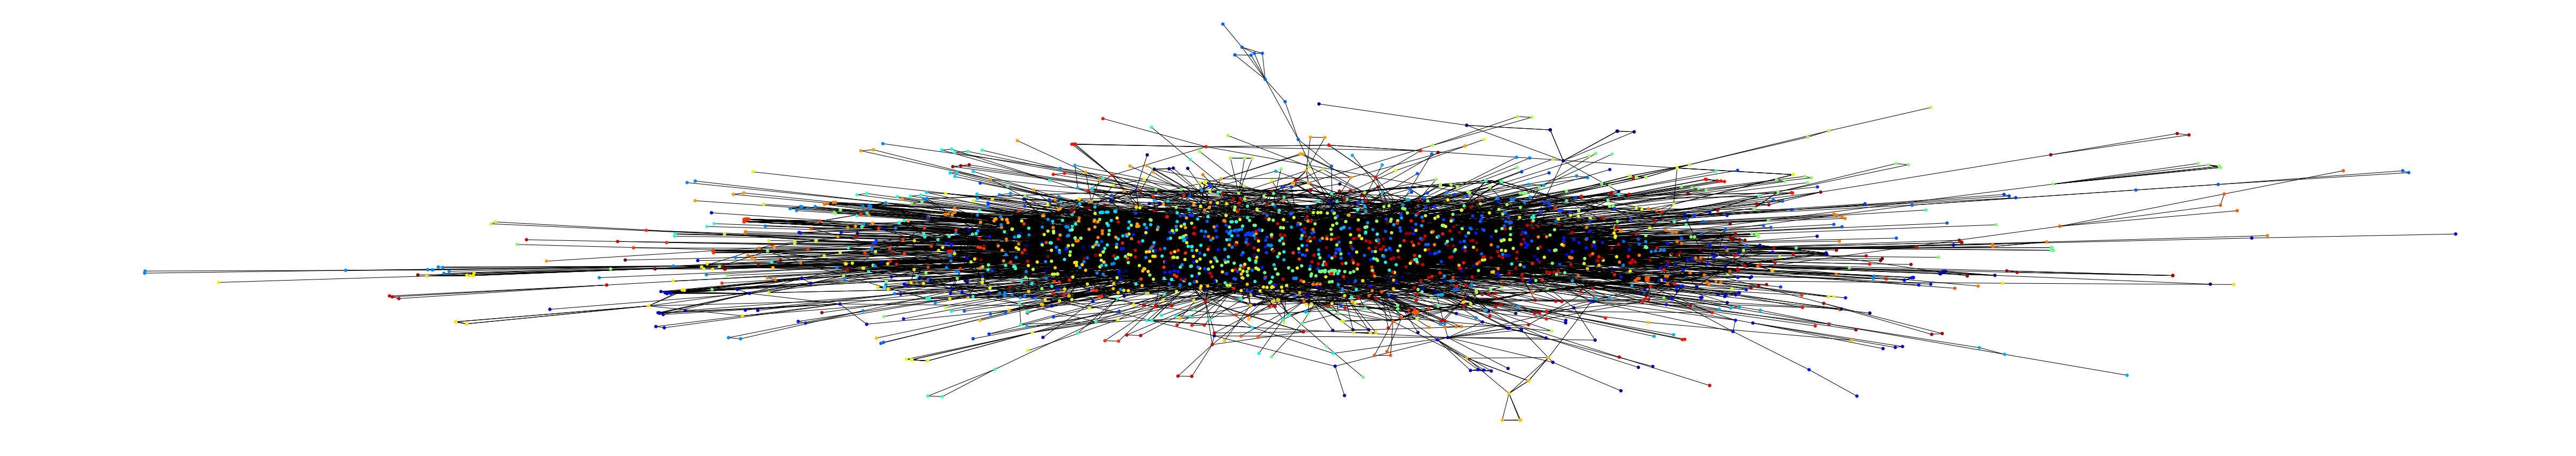

In [88]:
values = [business_Partitions.get(node) for node in businessPrjG.nodes()]
spring_pos = nx.spring_layout(businessPrjG)
plt.axis("off")
nx.draw_networkx(businessPrjG, pos = spring_pos, 
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = 35, with_labels = False)

### Distribution of Business Within Communities

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


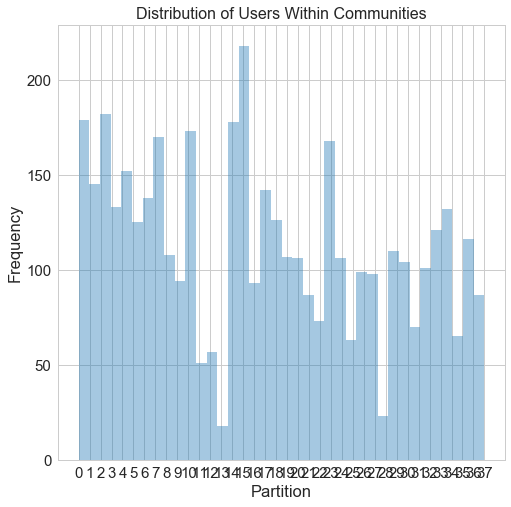

In [89]:
business_partitions_df = pd.DataFrame({'partition':business_Partitions})
plot_dist(business_partitions_df, np.arange(0,38,1), 38);

In [90]:
business_partitions_df['partition'].value_counts()

25    170
7     167
14    159
5     124
18    120
21    117
4     107
6     107
16    101
11     97
26     94
17     89
20     87
24     85
13     84
2      76
0      76
23     75
27     75
10     73
8      67
15     66
19     59
9      47
1      46
22     41
12     21
3       5
Name: partition, dtype: int64

Using the island method, we will reduce the size of the network under analysis by trimming some nodes.

In [91]:
islands2 = island_method(businessPrjG, 2)

print ('Weight  Users  Groups')
for i in islands2:
   print('{}       {}       {}'.format(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))
   
   
   
print ('%-25s %-45s %-13s' % ('Rating more than', 'Nodes(Users + Review)', 'Islands'))



1
3
1
Weight  Users  Groups
1       2435       1
2       51       23
Rating more than          Nodes(Users + Review)                         Islands      
1                         2435                                          [2435]       
2                         51                                            [2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [92]:
for i in islands2:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))   

1                         2435                                          [2435]       
2                         51                                            [2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [96]:
## Apply Island Analysis on the business nodes
cc = list(nx.connected_component_subgraphs(businessPrjG))[0]
islands = island_method(cc)

print ('Weight  Restaurant  Groups')
for i in islands:
    print(' %d          %2d       %d' 
          %(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Restaurant  Groups
 1          2435       1


### Calculate Centrality Measures of the Business node


In [93]:
print(getAllCentalityMeasures(businessPrjG).head(20))

                            Node  Closeness  Betweenness   Degrees     Eigen
341   BSN_YKOvlBNkF4KpUP9q7x862w   0.319297     0.038688  0.027116  0.164932
1937  BSN_ZoQAOnEFnyHjSpomtfqesA   0.303870     0.014134  0.023007  0.164821
2135  BSN_c7VgGP8xT25OSReok6fwcQ   0.298467     0.017984  0.024240  0.163883
550   BSN_YQvg0JCGRFUkb6reMMf3Iw   0.302210     0.013413  0.022186  0.163804
1404  BSN_XNSito__Fne14TXU0vz1Qw   0.291044     0.005409  0.019310  0.163402
471   BSN_Mb46iSlA4qmTwXf-WrqtQA   0.284612     0.010023  0.021364  0.163110
79    BSN_U4IipLI4RsuBLmxTFEV2MQ   0.298065     0.010213  0.021364  0.162976
330   BSN_fK7ujDbjhRFEe2D7eIwK4w   0.289727     0.009776  0.020953  0.162658
2321  BSN_B8ujMtvvpHyEQ2r_QlAT2w   0.294602     0.007913  0.019721  0.162593
811   BSN_jtzhY-P4H6WSYpv5rWhxtw   0.292372     0.009535  0.019310  0.162417
1700  BSN_zMa6YoEekpABg1HZnnTZdg   0.289417     0.001840  0.017256  0.162132
1911  BSN_8cL7aJVKTYmLguzXEAS3Lw   0.283848     0.006378  0.018077  0.161739

### Conclusion

We could see that top 20 business are having almost the same eigen vector centrality. Also we couldn't find any clear clustor or communities within the business nodes.So according to our analysis We couldn't find any business which clearly distinguish itself from other business.

We have noticed similar kind of behavior with user nodes as well.

Basically people are be visting different business according to their need and rate it based on their experince.


## Part 2 - NLP

Please find the recording for the Part 2

https://youtu.be/A_F2PSKlJeo

### Analyze Review Data
Our goal here is to analyze the review data.
#### Handling the Data

In [96]:
data_text = data_raw[["stars","text"]]

In [97]:
print(data_text)

      stars                                               text
0         5  My wife took me here on my birthday for breakf...
1         5  I have no idea why some people give bad review...
2         4  love the gyro plate. Rice is so good and I als...
3         5  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4         5  General Manager Scott Petello is a good egg!!!...
...     ...                                                ...
9995      3  First visit...Had lunch here today - used my G...
9996      4  Should be called house of deliciousness!\n\nI ...
9997      4  I recently visited Olive and Ivy for business ...
9998      2  My nephew just moved to Scottsdale recently so...
9999      5  4-5 locations.. all 4.5 star average.. I think...

[10000 rows x 2 columns]


In [98]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [100]:
# First we will remove contractions.
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

data_text['text']=data_text['text'].apply(lambda x:expand_contractions(x))

In [101]:
# Now we will turn every word into lowercase.
data_text['text']=data_text['text'].apply(lambda x: x.lower())

In [102]:
# Now we will remove punctuations.
data_text['text']=data_text['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [103]:
# Finally, we will remove numerals.
data_text['text']=data_text['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [104]:
text = data_text[['text']].values.tolist()

In [105]:
print(len(text))

10000


In [109]:
# flatten text
f_text = []
for i in text:
    for j in i:
        f_text.append(j)

In [110]:
ft = ' '.join(f_text)

In [111]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [112]:
# Make a list of all of the words
words = word_tokenize(ft)

In [113]:
words[0:10]

['my',
 'wife',
 'took',
 'me',
 'here',
 'on',
 'my',
 'birthday',
 'for',
 'breakfast']

Next we will remove stop words.

In [114]:
from nltk.corpus import stopwords

In [115]:
stop_words = set(stopwords.words('english'))

In [116]:
filtered_list = []

# store all of the non stop words.
for word in words:
    if word.casefold() not in stop_words:
        filtered_list.append(word)

In [117]:
filtered_list[0:10]

['wife',
 'took',
 'birthday',
 'breakfast',
 'excellent',
 'weather',
 'perfect',
 'made',
 'sitting',
 'outside']

Now we will remove these words to their root words.

In [118]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [119]:
lemmas = []
for w in filtered_list:
    lemmas.append(lemmatizer.lemmatize(w))

In [120]:
lemmas[0:10]

['wife',
 'took',
 'birthday',
 'breakfast',
 'excellent',
 'weather',
 'perfect',
 'made',
 'sitting',
 'outside']

#### Analyzing
Now that we have broken our original text down to the lemmas, we are ready to do some analysis.

In [121]:
# Tokens
from nltk import FreqDist
freq = FreqDist(lemmas)

In [122]:
freq.most_common(20)

[('place', 7370),
 ('good', 6768),
 ('food', 6261),
 ('great', 5067),
 ('like', 5039),
 ('time', 4534),
 ('would', 4288),
 ('one', 4267),
 ('get', 4118),
 ('go', 3620),
 ('really', 3348),
 ('service', 3180),
 ('back', 2866),
 ('also', 2507),
 ('love', 2355),
 ('little', 2216),
 ('nice', 2207),
 ('restaurant', 2177),
 ('well', 2103),
 ('make', 2017)]

In [123]:
# Bigrams
bigrams = nltk.bigrams(lemmas)
bigram_freq = FreqDist(bigrams)

In [124]:
# Trigrams
trigrams = nltk.trigrams(lemmas)
trigram_freq = FreqDist(trigrams)

#### Visualizations

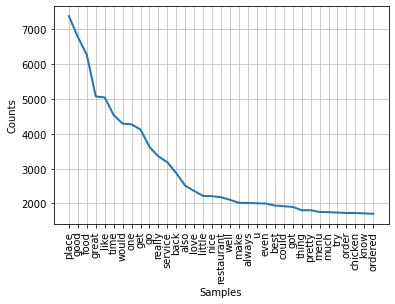

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [125]:
# Tokens frequency plot
freq.plot(35)

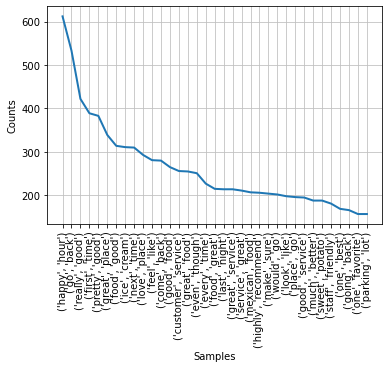

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [126]:
# Bigrams frequency plot
bigram_freq.plot(35)

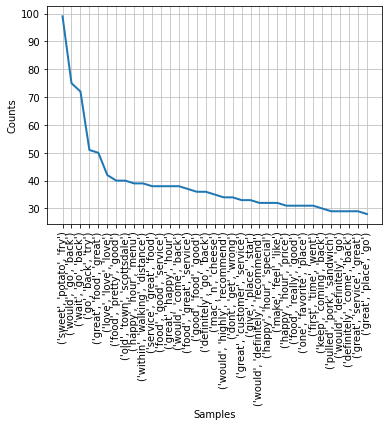

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [127]:
# Trigrams frequency plot
trigram_freq.plot(35)

### Rating Prediction
The goal here is to take the review data and split it into a training set and a test set. Then we train the training set until we can attempt to predict the test set. We want each review to be either rated as: 1, 2, 3, 4, or 5.

We will make three sets. A test_set of 1000 reviews, a dev_test set of 1000 reviews, and a train_set of 8000 reviews.

#### The Data
We will use the data from the beginning but we only need the reviews and the score.

In [132]:
data_text = data_text[["text", "stars"]]

In [133]:
dt_list = data_text.values.tolist()

#### Creating the Simulation
This will be done very much like project 3.

In [134]:
def accuracy(number_of_runs, function):
    accuracy_df = {
        "classifier": [],
        "train_set_acc": [],
        "dev_set_acc": [],
        "test_acc": []
    }
    for i in range(number_of_runs):
        random.shuffle(dt_list)
        dev_name_set = dt_list[0:1000]
        test_name_set = dt_list[1000:2000]
        train_name_set = dt_list[2000:]
        dev_set = [(function(n), i) for (n, i) in dev_name_set]
        test_set = [(function(n), i) for (n, i) in test_name_set]
        train_set = [(function(n), i) for (n, i) in train_name_set]
        classifier = nltk.NaiveBayesClassifier.train(train_set)
        accuracy_df["classifier"].append(classifier)
        accuracy_df["train_set_acc"].append(nltk.classify.accuracy(classifier, train_set))
        accuracy_df["dev_set_acc"].append(nltk.classify.accuracy(classifier, dev_set))
        accuracy_df["test_acc"].append(nltk.classify.accuracy(classifier, test_set))
    accuracy_df = pd.DataFrame.from_dict(accuracy_df)
    return(accuracy_df)

#### Creating Features
Now we can create features which classify the text based on certain conditions.

In [135]:
# Length of Review. Total characters.
def length_of_review(text):
    return {"length": len(text)}

In [136]:
char_amount_df = accuracy(100, length_of_review)

In [137]:
char_amount_df.describe()

,train_set_acc,dev_set_acc,test_acc
count,100.000000,100.000000,100.000000
mean,0.541526,0.342590,0.341830
std,0.001889,0.011909,0.013694
min,0.537000,0.312000,0.297000
25%,0.540250,0.334750,0.333000
50%,0.541562,0.343000,0.343500
75%,0.543031,0.349000,0.352000
max,0.545000,0.375000,0.373000


In [138]:
# The amount of words in a review.
def words_in_review(text):
    return {"length": len(text.split())}

In [139]:
word_amount_df = accuracy(100, words_in_review)

In [140]:
word_amount_df.describe()

,train_set_acc,dev_set_acc,test_acc
count,100.000000,100.000000,100.000000
mean,0.433464,0.349850,0.353760
std,0.002358,0.015064,0.013039
min,0.426625,0.319000,0.321000
25%,0.431969,0.341000,0.345000
50%,0.433688,0.350000,0.355000
75%,0.435000,0.358500,0.361000
max,0.439250,0.395000,0.390000


In [141]:
# If the letters "b" and "g" are in the review.
def b_n_g(review):
    return {"b_and_g": bool(re.match('^[bg]+$', review))}

In [142]:
b_n_g_df = accuracy(100, b_n_g)

In [143]:
b_n_g_df.describe()

,train_set_acc,dev_set_acc,test_acc
count,100.000000,100.000000,100.000000
mean,0.352759,0.352980,0.350950
std,0.002160,0.013949,0.014104
min,0.346500,0.317000,0.312000
25%,0.351375,0.343750,0.340750
50%,0.352375,0.355500,0.352000
75%,0.354156,0.362250,0.360000
max,0.358250,0.382000,0.387000


In [144]:
# Amount of words and amount of characters
def amounts(review):
    return {"char_len": len(review), "word_amount": len(review.split())}

In [145]:
amounts_df = accuracy(100, amounts)

In [146]:
amounts_df.describe()

,train_set_acc,dev_set_acc,test_acc
count,100.000000,100.000000,100.00000
mean,0.575645,0.324300,0.32426
std,0.002814,0.011057,0.01430
min,0.568875,0.300000,0.28300
25%,0.573937,0.317000,0.31700
50%,0.575937,0.323000,0.32450
75%,0.577375,0.331250,0.33200
max,0.582000,0.349000,0.37000


So clearly the features we have tried have not worked well. Our next attempt is to make a list of positive words and a list of negative words to use as features.

In [147]:
positive_words = ["good", "positive", "excellent", "fun", "awesome", "delicious", "wow", "affordable", "clean", "quick"]
negative_words = ["bad", "loud", "dirty", "dark", "gross", "expensive", "slow", "rude", "negative", "crowded"]

In [148]:
# Positive_words
def p_words(review):
    words = review.split()
    return {"matches": any(i in words for i in positive_words)}

In [149]:
positive_df = accuracy(100, p_words)

In [150]:
positive_df.describe()

,train_set_acc,dev_set_acc,test_acc
count,100.000000,100.000000,100.000000
mean,0.379602,0.377040,0.380140
std,0.002221,0.012345,0.012879
min,0.374250,0.346000,0.351000
25%,0.378125,0.369750,0.371750
50%,0.379750,0.378000,0.379500
75%,0.381031,0.386000,0.389000
max,0.384500,0.403000,0.409000


In [151]:
# Negative_words
def neg_words(review):
    words = review.split()
    return {"matches": any(i in words for i in negative_words)}

In [152]:
neg_df = accuracy(100, neg_words)

In [153]:
neg_df.describe()

,train_set_acc,dev_set_acc,test_acc
count,100.000000,100.000000,100.000000
mean,0.360637,0.361850,0.359050
std,0.002335,0.013007,0.013879
min,0.355375,0.329000,0.324000
25%,0.358875,0.354500,0.349000
50%,0.360687,0.363000,0.361000
75%,0.362406,0.370000,0.368000
max,0.366375,0.397000,0.390000


So that did no help much either. Let's see what happens if we combine them.

In [154]:
def common_words(review):
    words = review.split()
    return {"matches": any(i in words for i in (negative_words + positive_words))}

In [155]:
com_df = accuracy(100, common_words)

In [156]:
com_df.describe()

,train_set_acc,dev_set_acc,test_acc
count,100.000000,100.000000,100.000000
mean,0.381770,0.379440,0.384400
std,0.002613,0.015692,0.015022
min,0.373000,0.331000,0.343000
25%,0.380250,0.369000,0.376000
50%,0.381812,0.379500,0.386000
75%,0.383531,0.390250,0.393250
max,0.387500,0.418000,0.433000


#### Conclusions for the prediction model
That was hard, and surprising. The models that used review lengths as their features performed better than those that were matched to other lists. I imagine if we had a bigger list of the most commonly used positive and negative words are model would score much higher.